# Chinese text summarization algorithm
### www.KudosData.com
#### By: Sam GU Zhan
#### March, 2017

# Imports

In [1]:
# coding=UTF-8
from __future__ import division
import re

# Python2 unicode & float-division support:
# from __future__ import unicode_literals, division

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import io

# 中文字符和语言处理库
import jieba

# 机器学习库 sklearn 分类学习模型库
#from sklearn import linear_model
from sklearn.feature_extraction import DictVectorizer # 数据结构变换：把 Dict 转换为 稀疏矩阵
# from sklearn.linear_model import LogisticRegression  # 逻辑回归分类模型
# from sklearn.pipeline import make_pipeline # 封装机器学习模型流程
# from sklearn.metrics import confusion_matrix, roc_curve, auc

# 中文显示设置
from pylab import *  
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体  
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题 
mpl.rcParams['font.size'] = 14 # 设置字体大小

np.random.seed(88)

# Define Functions

In [3]:
# Python3
# 中文分词功能小函数， 输出 字符串， 各词组由空格分隔
def KudosData_word_tokenizer(foo):
    # remove lead & tail spaces firstly:
    foo = foo.strip()
    seg_token = jieba.cut(str(foo), cut_all=True)
    seg_str = str(' '.join(seg_token)).strip()

    return seg_str
# Python2
# 中文分词功能小函数， 输出 字符串， 各词组由空格分隔
# def KudosData_word_tokenizer(foo):
#     seg_token = jieba.cut(foo, cut_all=True)
#     seg_str = ' '.join(seg_token)
#     return seg_str

In [4]:
# Python3
# 中文分词功能小函数， 输出 dictionary： { key 词组， value 计数 }
def KudosData_word_count(foo):
    # remove lead & tail spaces firstly:
    foo = foo.strip()
    seg_token = jieba.cut(str(foo), cut_all=True)
    seg_str = str(' '.join(seg_token)).strip()
    seg_count = pd.value_counts(str(seg_str).lower().split(' '))
    seg_count = seg_count.to_dict() 
    seg_count.pop('', None) # remove EMPTY dict key: ''
    return seg_count
# Python2
# 中文分词功能小函数， 输出 dictionary： { key 词组， value 计数 }
# def KudosData_word_count(foo):
#     seg_token = jieba.cut(foo, cut_all=True)
#     seg_str = '^'.join(seg_token)
#     seg_count = pd.value_counts(seg_str.lower().split('^'))
#     return seg_count.to_dict()

# Input text

In [5]:
# process Unicode text input
with io.open('input_text.txt','r',encoding='utf8') as f:
    content = f.read()

title = '''
<Dummy Title>
'''

In [6]:
# content

In [7]:
def format_sentence(text):
#     sentence = re.sub(r'\W+', '#', sentence)
    text = re.sub(r'\t+', '', text) # remove one or more Tab
    return text

In [8]:
def extract_valid_sentence_words(text):
    text = re.sub(r'\W+', '#', text.strip())
    return text

In [9]:
def linebreak_conversion_win_linux(text):
    text = re.sub(r'\r', '', text) # remove one or more Tab
    text = re.sub(r'\u3000', ' ', text) # convert white space: \u3000    
    return text

In [10]:
def clean_some_whitespace(text): # Does not remove normal Space
#     sentence = re.sub(r'\W+', '#', sentence)
    text = re.sub(r'\t+', '', text) # remove one or more Tab
    text = re.sub(r'\f+', '', text) # remove one or more
    text = re.sub(r'\v+', '', text) # remove one or more
    text = re.sub(r'\n+', '', text) # remove one or more \n, this is to merge sentences within paragraph

    text = re.sub(r'(\^\*\#)( +)(\#\*\^)', '^*##*^', text) # remove one or more Spaces between Paragraph-Tags or Sentence-Tags

    text = re.sub(r' +', ' ', text) # merge two or more Spaces to 1 Space

    # remove lead & tail spaces:
    text =text.strip()

#     text = re.sub(r'( +)\W', r'\W', text) # remove Spaces before special char
#     text = re.sub(r'\W( +)', r'\W', text) # remove Spaces after special char
    
    return text

In [11]:
### Define Paragraph-Tag =  
#   #*^P^*#

### Define Sentence-Tag =  
#   #*^S^*#


In [12]:
# add a special tage to end of each paragraph
def tag_paragraph(text):
    text = re.sub(r'((\n ) +)+', '#*^P^*#', text) # Tag paragraph, pattern: \n + two or more Spaces
    text = re.sub(r'((\n\t) +)+', '#*^P^*#', text) # Tag paragraph, pattern: \n + two or more Tabs
    text = re.sub(r'(\n( *)\n)+', '#*^P^*#', text) # Tag paragraph, pattern: \n + zero or more Spaces + \n
    text = re.sub(r'(\#\*\^P\^\*\#)+', '#*^P^*#', text) # merge two or more Paragraph-Tags -> 1 Paragraph-Tag

    return text

In [13]:
# add a special tage to end of each sentence
def tag_sentence(text):
    text = re.sub(r'。+', '。#*^S^*#', text) # Tag sentence - Chinese
    text = re.sub(r'！+', '！#*^S^*#', text) # Tag sentence - Chinese
    text = re.sub(r'\？+', '？#*^S^*#', text) # Tag sentence - Chinese
    text = re.sub(r'；+', '；#*^S^*#', text) # Tag sentence - Chinese

    text = re.sub(r'!+', '!#*^S^*#', text) # Tag sentence - English
    text = re.sub(r'\?+', '?#*^S^*#', text) # Tag sentence - English
    text = re.sub(r';+', ';#*^S^*#', text) # Tag sentence - English
   
    # merge two or more sentence-Tags -> 1 Sentence-Tag
    text = re.sub(r'(\W?(\#\*\^S\^\*\#))+', '。#*^S^*#', text)

    # remove a Sentence-Tag immediately before an ending ”
    text = re.sub(r'\#\*\^S\^\*\#”', '”', text) 
    
    # remove a Sentence-Tag immediately before a Paragraph-Tag
    text = re.sub(r'(\#\*\^S\^\*\#)( *)(\#\*\^P\^\*\#)', '#*^P^*#', text) 
    
    text = re.sub(r'(\#\*\^P\^\*\#)+', '#*^P^*#', text) # merge two or more Paragraph-Tags -> 1 Paragraph-Tag

    
    return text

### Start tagging:

In [14]:
content_format = linebreak_conversion_win_linux(content)
# content_format

In [15]:
content_format = tag_paragraph(content_format)
# content_format

In [16]:
content_format = clean_some_whitespace(content_format)
# content_format

In [17]:
content_format = tag_sentence(content_format)
# content_format

In [18]:
content_format = clean_some_whitespace(content_format)
content_format

'中文缩写指南#*^P^*#标签: java面试之葵花宝典 转自: http://blog.chinaunix.net/uid-13990540-id-2850384.html二、中文缩写指南： #*^P^*#1、BT：①Bit Torrent的缩写，是一种P2P（点对点）共享软件，中文译名“比特流”或“变态下载”。#*^S^*#②“变态”的缩写。#*^S^*# 2、ZT：①“转帖”的缩写。#*^S^*#②“猪头”的缩写，引申有ZT3，猪头三。#*^S^*#ZT4，猪头四。#*^S^*# 例句：青眉郑重告诉侠客社区的侠友们，ZT一定要注明。#*^S^*# 3、PP：①“片片”的缩写，片片指代照片。#*^S^*#②“屁屁”的缩写，屁屁指代臀部。#*^S^*# 4、GG：哥哥的缩写，指代男性，有时候女生用来指代自己的男友。#*^S^*#与之相对的是MM，妹妹或者美眉的缩写，指代女性，有时候男生用来指代自己的女友。#*^S^*# 5、NB：牛×的缩写，北京方言里用来表示叹为观止之意。#*^S^*# 6、JJ：①姐姐的缩写。#*^S^*#②鸡鸡的缩写。#*^S^*# 7、DD：①弟弟的缩写，偶尔有引申义。#*^S^*#②东东的缩写，指代东西。#*^S^*# 8、GF：Girl Friend，女友。#*^S^*#与之相对的是BF，Boy Friend，男友。#*^S^*# 9、PLMM：漂亮美眉的缩写。#*^S^*# 10、PPMM：PLMM的升级版，漂漂美眉。#*^S^*# 11、RPWT：人品问题的缩写，来自猫扑论坛。#*^S^*#一般来说，只要某上遇上了不可解之事，统统可归结为其有RPWT。#*^S^*# 12、人品帖：测试你是否有RPWT的帖子，帖子题目很劲爆，只要你被骗进去，就说明你有RPWT。#*^S^*# 例句：这张名为《朴树的裸照》的帖子是个人品帖，其实里面真的是一棵朴树的照片啊，树当然是裸的，哪里有穿衣服的树。#*^S^*#青眉居然被这个人品帖骗进去了，果真有RPWT啊。#*^S^*# 13、PF：佩服的缩写。#*^S^*# 14、SL：色狼的缩写。#*^S^*# 15、KH：葵花，代指练《葵花宝典》的高手。#*^S^*# 16、KHBD：葵花宝典。#*^S^*# 17、PXJF：辟邪剑法，源于KHBD，KH专用的剑法。#*^S^*# 18、BS：鄙视的缩写


### Transfer tagged text to Pandas Dataframe

In [19]:
# Split a text into paragraphs
def split_article_to_paragraphs(text):
#     text = text.replace("#*^P^*#", "#*^S^*#") # convert Paragraph-Tag        
    return text.split("#*^P^*#")


In [20]:
# Split a paragraph into sentences
def split_paragraph_to_sentences(text):
#     text = text.replace("#*^P^*#", "#*^S^*#") # convert Paragraph-Tag        
    return text.split("#*^S^*#")


In [21]:
# 1st loop Paragraphs list, 2nd loop Sentences list
# create a few new columns, then write into dataframe, together with original Sentence string

# define empty dataframe:
df_article = pd.DataFrame(columns=('sentence', 
                                   'word_count', # sentence word count, including punctuations 
                                   'sentence_id', # unique sentence s/n within an article
                                   'sentence_id_paragraph',  # sentence s/n within a paragraph 
                                   'paragraph_id', 
                                   'class_rank', 
                                   'score_word', # score based on word tf-idf
                                   'score_sentence', # score based on intersection of sentence pairs
                                   'score_word_norm', # Normalized score
                                   'score_sentence_norm', # Normalized score
                                   'score',
                                  ))
df_sentence_id = 0

# split_article_to_paragraphs:
article_paragraphs = split_article_to_paragraphs(content_format)

for i in range(0, len(article_paragraphs)):
    # split_paragraph_to_sentences:
    article_paragraphs_sentences = split_paragraph_to_sentences(article_paragraphs[i].strip())

    for j in range(0, len(article_paragraphs_sentences)):
        if article_paragraphs_sentences[j].strip() != '':
            df_sentence_id = df_sentence_id + 1
            # write to dataframe:
            df_article.loc[len(df_article)] = [article_paragraphs_sentences[j].strip(), 
                                               len(article_paragraphs_sentences[j].strip()), 
                                               df_sentence_id, 
                                               j+1, 
                                               i+1, 
                                               '', 
                                               '', 
                                               '', 
                                               '', 
                                               '', 
                                               '']


In [22]:
# Make sure no empty sentences:
print('Number of empty sentences in dataframe: %d ' % len(df_article[df_article['sentence'] == '']))

Number of empty sentences in dataframe: 0 


In [23]:
df_article

,sentence,word_count,sentence_id,sentence_id_paragraph,paragraph_id,class_rank,score_word,score_sentence,score_word_norm,score_sentence_norm,score
0,中文缩写指南,6,1,1,1,,,,,,
1,标签: java面试之葵花宝典 转自: http://blog.chinaunix.net/...,83,2,1,2,,,,,,
2,1、BT：①Bit Torrent的缩写，是一种P2P（点对点）共享软件，中文译名“比特流”...,54,3,1,3,,,,,,
3,②“变态”的缩写。,9,4,2,3,,,,,,
4,2、ZT：①“转帖”的缩写。,14,5,3,3,,,,,,
5,②“猪头”的缩写，引申有ZT3，猪头三。,20,6,4,3,,,,,,
6,ZT4，猪头四。,8,7,5,3,,,,,,
7,例句：青眉郑重告诉侠客社区的侠友们，ZT一定要注明。,26,8,6,3,,,,,,
8,3、PP：①“片片”的缩写，片片指代照片。,21,9,7,3,,,,,,
9,②“屁屁”的缩写，屁屁指代臀部。,16,10,8,3,,,,,,


In [24]:
# assume the 1st sentence as Title of Article

title = df_article['sentence'][0]
print('Title of Article : ', title)

Title of Article :  中文缩写指南


# Calculate importance score for each sentence

### [Optional Reference] word_tokenizer

In [25]:
# KudosData_word_tokenizer
df_article['sentence_tokenized'] = df_article['sentence'].apply(lambda x: KudosData_word_tokenizer(x))

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\TELESC~1\AppData\Local\Temp\jieba.cache
DEBUG:jieba:Loading model from cache C:\Users\TELESC~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.800 seconds.
DEBUG:jieba:Loading model cost 1.800 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


### [Optional Reference] Term Frequency

In [26]:
# KudosData_word_count
df_article['sentence_tf'] = df_article['sentence'].apply(lambda x: KudosData_word_count(x))

### [Optional Reference] TF-IDF

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = df_article['sentence_tokenized']

vectorizer = TfidfVectorizer()

# my_stopword_list = ['and','to','the','of', 'in']
#vectorizer = TfidfVectorizer(stop_words=my_stopword_list)

# choice of no nomalization of tfidf output (not recommended)
#vectorizer = TfidfVectorizer(norm=None)

# TF-IDF score
tfidf = vectorizer.fit_transform(corpus)

# IDF score
idf_dict = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

# TF is in df_article[['sentence_tf']]

In [28]:
### 把TF-iDF数值赋予相对应的词组
tfidf = tfidf.tocsr()

n_docs = tfidf.shape[0]
tfidftables = [{} for _ in range(n_docs)]
terms = vectorizer.get_feature_names()

for i, j in zip(*tfidf.nonzero()):
    tfidftables[i][terms[j]] = tfidf[i, j]

In [29]:
# Document-Term-Matrix's TF-IDF matrix size:
print ('This tfidf matrix is a very large table: [ %d rows/docs X %d columns/words ]' 
       % (tfidf.shape[0], tfidf.shape[1]))
print ('It contains %d eliments: one score per word per document !'
       % (tfidf.shape[0] * tfidf.shape[1]))

This tfidf matrix is a very large table: [ 78 rows/docs X 407 columns/words ]
It contains 31746 eliments: one score per word per document !


In [30]:
# Add tfidf score into dataframe 
df_article['tfidf'] = tfidftables

In [31]:
# df_article[['sentence', 'sentence_tokenized', 'tfidf']].head()
df_article[['sentence', 'sentence_tokenized', 'sentence_tf', 'tfidf']]

,sentence,sentence_tokenized,sentence_tf,tfidf
0,中文缩写指南,中文 缩写 指南,"{'缩写': 1, '中文': 1, '指南': 1}","{'缩写': 0.309927239451, '中文': 0.648463527319, '..."
1,标签: java面试之葵花宝典 转自: http://blog.chinaunix.net/...,标签 java 面试 之 葵花 葵花宝典 宝典 转 自 http blog ...,"{'id': 1, '葵花': 1, '宝典': 1, 'uid': 1, '标签': 1,...","{'id': 0.250769847432, '13990540': 0.250769847..."
2,1、BT：①Bit Torrent的缩写，是一种P2P（点对点）共享软件，中文译名“比特流”...,1 BT Bit Torrent 的 缩写 是 一种 P2P 点对点 共享 共享...,"{'或': 1, 'p2p': 1, '比特流': 1, '软件': 1, '是': 1, ...","{'p2p': 0.255780588652, '变态': 0.233602779459, ..."
3,②“变态”的缩写。,变态 的 缩写,"{'缩写': 1, '变态': 1, '的': 1}","{'缩写': 0.407131664977, '变态': 0.913369480207}"
4,2、ZT：①“转帖”的缩写。,2 ZT 转 帖 的 缩写,"{'转': 1, '缩写': 1, '帖': 1, 'zt': 1, '2': 1, '的'...","{'缩写': 0.451708041735, 'zt': 0.892165817005}"
5,②“猪头”的缩写，引申有ZT3，猪头三。,猪头 的 缩写 引申 有 ZT3 猪头 三,"{'三': 1, '有': 1, 'zt3': 1, '的': 1, '缩写': 1, '猪...","{'zt3': 0.432894152557, '缩写': 0.1762302788, '猪..."
6,ZT4，猪头四。,ZT4 猪头 四,"{'四': 1, 'zt4': 1, '猪头': 1}","{'zt4': 0.738393516768, '猪头': 0.674370087115}"
7,例句：青眉郑重告诉侠客社区的侠友们，ZT一定要注明。,例句 青 眉 郑重 告诉 侠客 社区 的 侠 友 们 ZT 一定 定要 注明,"{'们': 1, '郑重': 1, '例句': 1, '一定': 1, '社区': 1, '...","{'例句': 0.302442487686, '告诉': 0.355073439036, '..."
8,3、PP：①“片片”的缩写，片片指代照片。,3 PP 片片 的 缩写 片片 指代 照片,"{'片片': 2, '3': 1, '照片': 1, '指代': 1, '缩写': 1, '...","{'片片': 0.779375463151, '照片': 0.355899318619, '..."
9,②“屁屁”的缩写，屁屁指代臀部。,屁屁 的 缩写 屁屁 指代 臀部,"{'臀部': 1, '屁屁': 2, '缩写': 1, '的': 1, '指代': 1}","{'臀部': 0.416990472965, '缩写': 0.169755925031, '..."


### Scoring (1)
### Calculate score_word for each sentence, based on sentence word_count tf-idf:

In [32]:
# experiment: use tf-idf and len(sentence_tokenized) to calculate score
# tmp_mean = tmp_sum / len(df_article['sentence_tokenized'][i])

for i in range(0,len(df_article)):
    if len(df_article['tfidf'][i]) == 0:
        df_article['score_word'][i] = 0
    else:
        tmp_sum = 0
        for key, values in df_article['tfidf'][i].items():
            tmp_sum += values
        
        tmp_mean = tmp_sum / len(df_article['sentence_tokenized'][i])
        df_article['score_word'][i] = tmp_mean 


G:\Tool_PGM\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Scoring (2)
### Calculate score_sentence for each sentence, based on pair-wise sentence comparison/intersection:

In [33]:
# Caculate raw intersection score between pair of two sentences, from df_article['sentence_tokenized']
def sentences_intersection(sent1tokenized, sent2tokenized):
    # www.KudosData.com - Chinese
    # split the sentence into words/tokens
    s1 = set(sent1tokenized.split(" "))
    s2 = set(sent2tokenized.split(" "))

    # If there is not intersection, just return 0
    if (len(s1) + len(s2)) == 0:
        print('# If there is not intersection, just return 0')
        return 0

    # Normalize the result by the average number of words
    return len(s1.intersection(s2)) / ((len(s1) + len(s2)) / 2)


### Below step runs long time... Tuning needed

In [34]:
# Calculate important score of every pair of sentences

n = len(df_article['sentence_tokenized'])
        
# [Sam python 2.7 -> 3.4] values = [[0 for x in xrange(n)] for x in xrange(n)]
df_score_raw_values = [[0 for x in range(n)] for x in range(n)]
for i in range(0, n):
    for j in range(0, n):
        df_score_raw_values[i][j] = sentences_intersection(df_article['sentence_tokenized'][i], 
                                                           df_article['sentence_tokenized'][j])

# The score of a sentence is the sum of all its intersection
sentences_dic = {}

for i in range(0, n):
    df_score = 0
    for j in range(0, n):
        if i == j:
            continue
        df_score += df_score_raw_values[i][j]
    df_article['score_sentence'][i] = df_score


G:\Tool_PGM\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [35]:
# df_article.head()

### Visualize Data

In [36]:
df_article[df_article['word_count'] == None]

,sentence,word_count,sentence_id,sentence_id_paragraph,paragraph_id,class_rank,score_word,score_sentence,score_word_norm,score_sentence_norm,score,sentence_tokenized,sentence_tf,tfidf


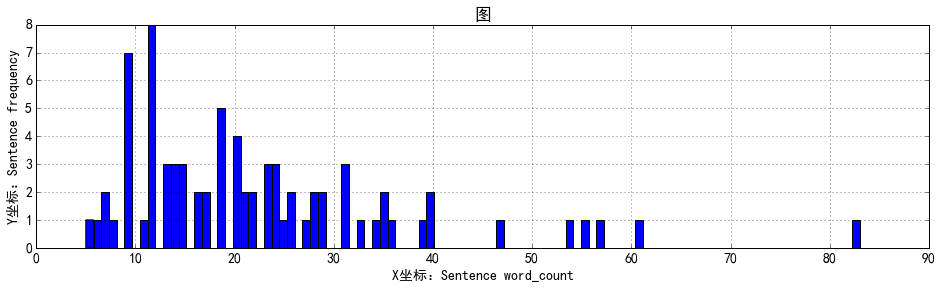

In [37]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：Sentence word_count')  
plt.ylabel(u'Y坐标：Sentence frequency')  
# df_article['word_count'].value_counts().sort_values(ascending=False).plot(kind='bar', color='green')
df_article['word_count'].hist(bins=100)
# plt.gca().invert_yaxis()
plt.show()


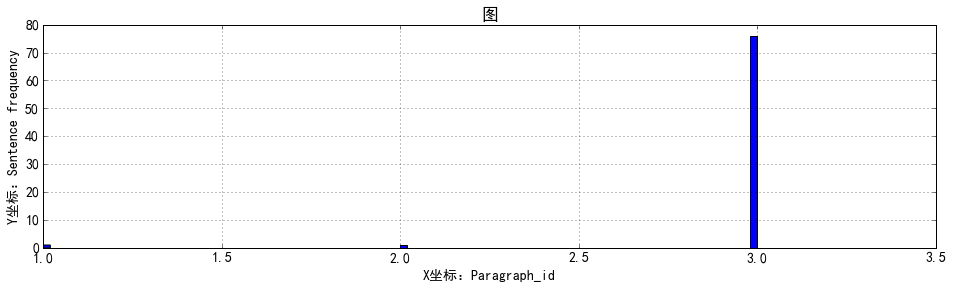

In [38]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：Paragraph_id')  
plt.ylabel(u'Y坐标：Sentence frequency')  
df_article['paragraph_id'].hist(bins=100)
# plt.gca().invert_yaxis()
plt.show()


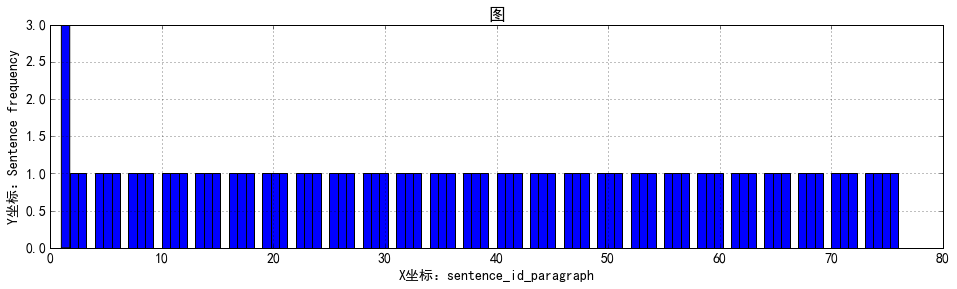

In [39]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：sentence_id_paragraph')  
plt.ylabel(u'Y坐标：Sentence frequency')  
df_article['sentence_id_paragraph'].hist(bins=100)
# plt.gca().invert_yaxis()
plt.show()


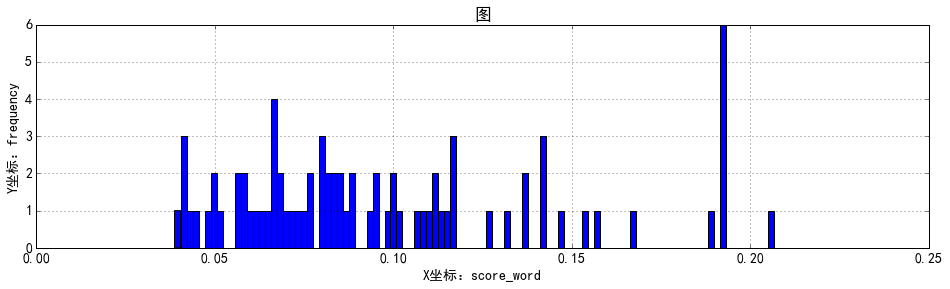

In [40]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：score_word')  
plt.ylabel(u'Y坐标：frequency')  
df_article['score_word'].hist(bins = 100)
# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(0,0.5)
#plt.ylim(0,0.5)
# plt.gca().invert_yaxis()
plt.show()


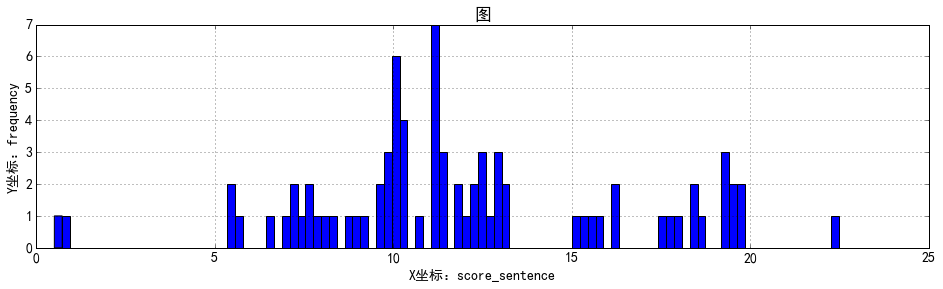

In [41]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：score_sentence')  
plt.ylabel(u'Y坐标：frequency')  
df_article['score_sentence'].hist(bins = 100)
# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(0,0.5)
#plt.ylim(0,0.5)
# plt.gca().invert_yaxis()
plt.show()


In [42]:
# df_article[(df_article['score_word'] > 0.15) & (df_article['score_word'] < 0.25)]
# df_article[(df_article['score_word'] > 0.2)].sort_values(by=['score_sentence', 'score_word'], ascending=[False, False,])
# df_article[(df_article['score_sentence'] > 250)].sort_values(by=['score_word', 'score_sentence'], ascending=[False, False,])


### Score Normalization

In [43]:
# log(score_word)
df_article['score_word_log'] = np.log(df_article['score_word'].astype('float64') + 
                                      df_article[df_article['score_word'] >0 ]['score_word'].min()/2)


In [44]:
# Normalize score_word_log

# df_article['score_word_norm'] = (df_article['score_word'] - df_article['score_word'].mean()) / df_article['score_word'].std()
df_article['score_word_norm'] = (df_article['score_word_log'] - df_article['score_word_log'].mean()) / df_article['score_word_log'].std()

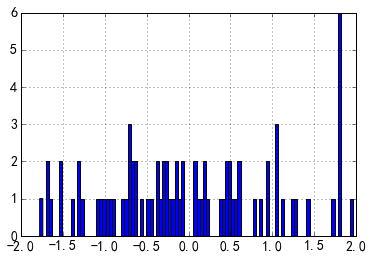

In [45]:
df_article['score_word_norm'].hist(bins=100)

In [46]:
# Normalize score_sentence

df_article['score_sentence_norm'] = (df_article['score_sentence'] - df_article['score_sentence'].mean()) / df_article['score_sentence'].std()

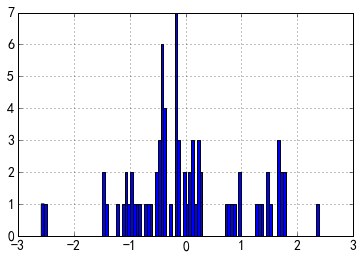

In [47]:
df_article['score_sentence_norm'].hist(bins=100)

### Generate class_rank

In [48]:
# Score integration
# df_article['score'] = (df_article['score_sentence_norm'] + df_article['score_word_norm']) / 2

# Sam Gu: 23 Mar 2017 - Experiment found that the score_word, which is based on tf-idf, doesn't seem to work well.
#                       score_word     tends to favor short sentences
#                       score_sentence tends to favor long  sentences
#                       Hence, here we use score_sentence only for final scoring.

df_article['score'] = df_article['score_sentence']
# df_article['score'] = df_article['score_word']

In [49]:
# Min-Max normalization:
df_article['score'] = (df_article['score'] - df_article['score'].min()) / (df_article['score'].max() -df_article['score'].min())

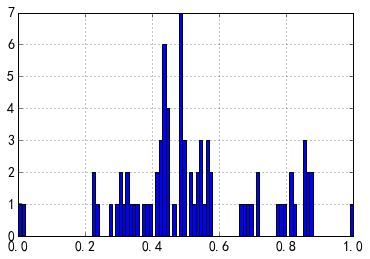

In [50]:
df_article['score'].hist(bins=100)

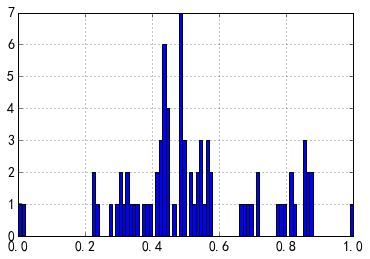

In [51]:
df_article['score'].hist(bins=100)

In [52]:
# sort firstly
df_article = df_article.sort_values(by=['paragraph_id', 'score'], ascending=[True, False]).reset_index(drop=True)

### Below step runs long time... Tuning needed

In [53]:
# Generate Class_Rank

current_class_rank = 0
current_paragraph_id = 0

for i in range(0, len(df_article)):
    if df_article['paragraph_id'][i] != current_paragraph_id: # change of Paragraph, thus reset class_rank
        current_class_rank = 1
        current_paragraph_id = df_article['paragraph_id'][i]
    else:
        current_class_rank = current_class_rank + 1
        
    df_article['class_rank'][i] = current_class_rank


G:\Tool_PGM\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [54]:
# sort Dataframe to 'result lookup mode'
df_article = df_article.sort_values(by=['class_rank', 'score', 'paragraph_id', 'sentence_id'], 
                                    ascending=[True, False, True, True]).reset_index(drop=True)

In [70]:
df_article[['sentence',
           'paragraph_id',
           'sentence_id_paragraph',
           'class_rank',
           'score',
           'sentence_tokenized'
          ]]

,sentence,paragraph_id,sentence_id_paragraph,class_rank,score,sentence_tokenized
0,②“变态”的缩写。,3,2,1,1,变态 的 缩写
1,标签: java面试之葵花宝典 转自: http://blog.chinaunix.net/...,2,1,1,0.300146,标签 java 面试 之 葵花 葵花宝典 宝典 转 自 http blog ...
2,中文缩写指南,1,1,1,0.220935,中文 缩写 指南
3,②“屁屁”的缩写，屁屁指代臀部。,3,8,2,0.878121,屁屁 的 缩写 屁屁 指代 臀部
4,②东东的缩写，指代东西。,3,15,3,0.878121,东东 的 缩写 指代 东西
5,22、BC：“白痴”的缩写。,3,35,4,0.866222,22 BC 白痴 的 缩写
6,6、JJ：①姐姐的缩写。,3,12,5,0.865192,6 JJ 姐姐 的 缩写
7,13、PF：佩服的缩写。,3,25,6,0.856194,13 PF 佩服 的 缩写
8,14、SL：色狼的缩写。,3,26,7,0.856194,14 SL 色狼 的 缩写
9,39、JS：“奸商”的缩写。,3,54,8,0.856194,39 JS 奸商 的 缩写


In [56]:
# df_article[(df_article['score'] == 0) | (df_article['score'] == 1)]

# Extract results based on user parameters:
* Max number of words
* % of original number of words
* Max lines of sentences


In [57]:
# Make a dataframe copy
df_article_internal = pd.DataFrame.copy(df_article)

In [58]:
total_words_original_article = df_article['sentence'].map(len).sum()
total_words_internal_article = df_article_internal['sentence'].map(len).sum()
# total_words_article_summary  = df_article_final['sentence'].map(len).sum()

# print('total_words_original_article : ', total_words_original_article)
# print('total_words_internal_article : ', total_words_internal_article)
# print('total_words_article_summary  : ', total_words_article_summary)


In [59]:
# Sam Gu: experiment shows no major improvement to use code in this block:

'''

# Heuristic cleaning:
# 1.Remove sentences, which has only one valid word. 
# 2.Remove paragraph, which has only single sentence.

# 1.
df_article_internal = df_article_internal[df_article_internal['sentence_tokenized'].map(len) > 1]
print('*** www.KudosData.com *** Removed number of sentences, which has only one valid word : %d'
      % (len(df_article) - len(df_article_internal)))

# 2.
df_article_internal_paragraph = df_article_internal['paragraph_id'].value_counts().to_frame(name = 'sentence_count')
df_article_internal_paragraph = df_article_internal_paragraph[df_article_internal_paragraph['sentence_count'] > 1]
valid_paragraph_id = df_article_internal_paragraph.index.tolist()
df_article_internal = df_article_internal[df_article_internal['paragraph_id'].isin(valid_paragraph_id)] 
print('*** www.KudosData.com *** Removed number of sentences in total : %d' % (len(df_article) - len(df_article_internal)))

# sort Dataframe to 'result lookup mode'
df_article_internal = df_article_internal.sort_values(by=['class_rank', 'score', 'paragraph_id', 'sentence_id'], 
                                    ascending=[True, False, True, True]).reset_index(drop=True)
# Above sort a must sort !!! for below processing:
# Loop Dataframe, accumulate length of sentences, stop when parm_max_word reached, return the index(), cut dataframe to display

'''

"\n\n# Heuristic cleaning:\n# 1.Remove sentences, which has only one valid word. \n# 2.Remove paragraph, which has only single sentence.\n\n# 1.\ndf_article_internal = df_article_internal[df_article_internal['sentence_tokenized'].map(len) > 1]\nprint('*** www.KudosData.com *** Removed number of sentences, which has only one valid word : %d'\n      % (len(df_article) - len(df_article_internal)))\n\n# 2.\ndf_article_internal_paragraph = df_article_internal['paragraph_id'].value_counts().to_frame(name = 'sentence_count')\ndf_article_internal_paragraph = df_article_internal_paragraph[df_article_internal_paragraph['sentence_count'] > 1]\nvalid_paragraph_id = df_article_internal_paragraph.index.tolist()\ndf_article_internal = df_article_internal[df_article_internal['paragraph_id'].isin(valid_paragraph_id)] \nprint('*** www.KudosData.com *** Removed number of sentences in total : %d' % (len(df_article) - len(df_article_internal)))\n\n# sort Dataframe to 'result lookup mode'\ndf_article_intern

### Accept user parameters:

In [60]:
# valid range: >= 0
parm_max_word = 200

# valid range: >= 0
parm_max_sentence = 5

# valid range: >=0
parm_max_percent = 0.01

### Validation of user parameters:

In [61]:
if (isinstance(parm_max_word, int) | isinstance(parm_max_word, float)):
    if parm_max_word >= 0:
        print('!1! valid input parm_max_word : ', parm_max_word)
    else:
        print('!2! Invalid input parm_max_word : ', parm_max_word)    
else:
    print('!3! Invalid input parm_max_word : ', parm_max_word)

if (isinstance(parm_max_sentence, int) | isinstance(parm_max_sentence, float)):
    if parm_max_sentence >= 0:
        print('!1! valid input parm_max_sentence : ', parm_max_sentence)
    else:
        print('!2! Invalid input parm_max_sentence : ', parm_max_sentence)    
else:
    print('!3! Invalid input parm_max_sentence : ', parm_max_sentence)

if (isinstance(parm_max_percent, int) | isinstance(parm_max_percent, float)):
    if parm_max_percent >= 0:
        print('!1! valid input parm_max_percent : ', parm_max_percent)
    else:
        print('!2! Invalid input parm_max_percent : ', parm_max_percent)    
else:
    print('!3! Invalid input parm_max_percent : ', parm_max_percent)


!1! valid input parm_max_word :  200
!1! valid input parm_max_sentence :  5
!1! valid input parm_max_percent :  0.01


In [62]:
# cut by parm_max_percent

# Loop Dataframe, accumulate length of sentences, stop when parm_max_word reached, return the index(), cut dataframe to display

sum_current_word = 0
cut_index = len(df_article_internal['sentence'])

# print('Start loop...')
for s in range(0, len(df_article_internal['sentence'])):
#     print('s : %d' % s)
    if sum_current_word / total_words_original_article <= parm_max_percent:
        sum_current_word += len(df_article_internal['sentence'][s])
    else:
#         stop, return index number
        cut_index = s - 1
        sum_current_word -= len(df_article_internal['sentence'][s-1])

#         print('To break')
        break

# print('End loop')
sum_current_percent = sum_current_word / total_words_original_article
print('---------- cut by parm_max_percent :')
print('sum_current_word  / total_words_original_article:', sum_current_percent)
print('cut_index : ', cut_index)

---------- cut by parm_max_percent :
sum_current_word  / total_words_original_article: 0.005122367672168469
cut_index :  1


In [63]:
# cut by parm_max_word

# Loop Dataframe, accumulate length of sentences, stop when parm_max_word reached, return the index(), cut dataframe to display

sum_current_word = 0
cut_index = len(df_article_internal['sentence'])

# print('Start loop...')
for s in range(0, len(df_article_internal['sentence'])):
#     print('s : %d' % s)
    if sum_current_word <= parm_max_word:
        sum_current_word += len(df_article_internal['sentence'][s])
    else:
#         stop, return index number
        cut_index = s - 1
        sum_current_word -= len(df_article_internal['sentence'][s-1])
#         print('To break')
        break

# print('End loop')
print('---------- cut by parm_max_word :')
print('sum_current_word :', sum_current_word)
print('cut_index : ', cut_index)

---------- cut by parm_max_word :
sum_current_word : 190
cut_index :  10


In [64]:
# cut by parm_max_sentence

cut_index = parm_max_sentence

print('---------- cut by parm_max_sentence :')
print('cut_index : ', cut_index)

---------- cut by parm_max_sentence :
cut_index :  5


In [65]:
# Extract top number of sentences as summary, based on: cut_index
df_article_final = df_article_internal[0:cut_index]

In [66]:
# sort by original sentence order 
df_article_final = df_article_final.sort_values(by=['sentence_id'], ascending=[True])
df_article_final[['sentence', 'paragraph_id', 'sentence_id_paragraph', 'class_rank', 'score']]

,sentence,paragraph_id,sentence_id_paragraph,class_rank,score
2,中文缩写指南,1,1,1,0.220935
1,标签: java面试之葵花宝典 转自: http://blog.chinaunix.net/...,2,1,1,0.300146
0,②“变态”的缩写。,3,2,1,1
3,②“屁屁”的缩写，屁屁指代臀部。,3,8,2,0.878121
4,②东东的缩写，指代东西。,3,15,3,0.878121


In [67]:
# total_words_original_article = df_article['sentence'].map(len).sum()
# total_words_internal_article = df_article_internal['sentence'].map(len).sum()
total_words_article_summary  = df_article_final['sentence'].map(len).sum()

print('total_words_original_article : ', total_words_original_article)
print('total_words_internal_article : ', total_words_internal_article)
print('total_words_article_summary  : ', total_words_article_summary)


total_words_original_article :  1757
total_words_internal_article :  1757
total_words_article_summary  :  126


# Output results to a file

In [68]:
# print('\n'.join(list(df_article_final['sentence'])))

In [69]:

with io.open('output_topic_summary.txt','w',encoding='utf8') as f:
#     f.write("Original Length : %s" % total_words_original_article)
    f.write("No. Paragraphs  : %d" % df_article_internal['paragraph_id'].max())
    f.write("\n")
    f.write("Original Length : %s" % total_words_internal_article)
    f.write("\n")
    f.write("Summary  Length : %s" % total_words_article_summary)
    f.write("\n")
#     f.write("Summary  Ratio  : %s %%" % (100 * (sum_current_word / total_words_original_article)))
    f.write("Summary  Ratio  : %.2f %%" % (100 * (total_words_article_summary / total_words_internal_article)))
    f.write("\n")
    f.write("\n")
    f.write("Title of Article: %s" % title)
    f.write("\n")
    f.write("\n")
    f.write('\n'.join(list(df_article_final['sentence'])))
    f.close()
    